In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Calibration

**Author:** Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2021

**Description:**

This notebook provides calibration benchmarks for any version of the *protopipe* pipeline.

**Requirements and steps to reproduce:**

It can be used with any camera and any image extractor from any simtel file of any production supported by *ctapipe*.

To get a filled notebook,

- get the necessary input files using ``ctapipe-stage1``
- execute the notebook (you can use ``papermill``)

To recreate these results,

- Create 1st pass DL1a data,


``ctapipe-stage1 --config protopipe_CTAMARS_1stPass_DL1a.json``
<br>
``--input gamma_20deg_180deg_run100__cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz``

- Create 2nd pass DL1a data,

``ctapipe-stage1 --config protopipe_CTAMARS_2ndPass_DL1a.json``
<br>
``--input gamma_20deg_180deg_run100__cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz``

- execute the notebook,

``papermill benchmarks_DL1a_calibration.ipynb results_benchmarks_DL1a_calibration.ipynb``
<br>
``-p input_file events_protopipe_CTAMARS_calibration_1stPass.dl1.h5``
<br>
``-p input_file_2ndPass events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5``
<br>
``-p config protopipe_CTAMARS_1stPass_DL1a.json``
<br>
``-p provenance_file ctapipe-stage1.provenance.log``

You can pretty-print it in HTML format with,

``jupyter nbconvert results_benchmarks_DL1a_calibration.ipynb``
<br>
``--to html --TagRemovePreprocessor.remove_cell_tags "remove_input" --no-input``

To obtain the list of all available parameters you can do,

``papermill --help-notebook benchmarks_DL1a_calibration.ipynb``

In general, for what concerns the comparison between *protopipe* and *CTAMARS*:

- the simtel file has to be ``gamma_20deg_180deg_run100__cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz``
- ``calibscale`` should be set to 0.92
- the configuration files have to be the ones provided in the same folder as this notebook.

## Table of contents

- [Correlation between reconstructed and true number of photoelectrons](#Correlation-between-reconstructed-and-true-number-of-photoelectrons)
- [Charge resolution](#Charge-resolution)
- [Average residual bias](#Average-residual-bias)
- [Charge resolution corrected for the average residual bias](#Charge-resolution-corrected-for-the-average-residual-bias)
- [RMS of charge resolution around 1](#RMS-of-charge-resolution-around-1)
- [Single-pixels spectra and optimized cleaning thresholds](#Single-pixels-spectra-and-optimized-cleaning-thresholds)

## Imports
[back to top](#Table-of-contents)

In [2]:
from pathlib import Path
import json

import uproot
import numpy as np
import astropy.units as u
from astropy.table import Column, vstack, join
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#%config InlineBackend.figure_format = 'svg'

import ctapipe
from ctapipe.instrument import SubarrayDescription
try:
    from ctapipe.io import read_table
except ImportError:
    from ctapipe.io.astropy_helpers import h5_table_to_astropy as read_table

## Functions
[back to top](#Table-of-contents)

In [3]:
def compute_weight_BTEL1010(true_energy):
    """Compute the weight from requirement B-TEL-1010-Intensity-Resolution."""
    target_slope = -2.62 # this is the spectral slope as required by the B-TEL-1010 "Intensity Resolution" doc
    spec_slope = -2.0 # this is the spectral slope in the simtel files
    # each pixel of the same image (row of data table) needs the same weight
    weight = np.power(true_energy/200., target_slope - spec_slope)
    return weight

In [4]:
def calc_bias(x_bin_edges, y_bin_edges, hist):
    """Calculate the average bias of charge resolution from 50 to 500 true photoeletrons.
    These limits are chosen in order to be safely away from saturation and from NSB noise.
    
    Parameters
    ----------
    x_bin_edges : 1D array
        Bin edges in true photoelectrons.
    y_bin_edges : 1D array
        Bin edges in reconstructed/true photoelectrons.
    hist : 2D array
        The full histogram of reconstructed/true against true photoelectrons.
        
    Returns
    -------
    bias : float
        Average bias of charge resolution from 50 to 500 true photoelectrons.
    
    """
    min_edge_index = np.digitize(1.7, x_bin_edges) - 1
    max_edge_index = np.digitize(2.7, x_bin_edges)

    proj = np.zeros(600)
    for i in range(min_edge_index, max_edge_index + 1):
        proj = proj + hist[i]

    y_bin_centers = 0.5*(y_bin_edges[1:] + y_bin_edges[:-1])

    bias = 1./np.average(y_bin_centers, weights = proj)
    
    return bias

In [5]:
def calc_rms(values, weights):
    """Root Mean Square around 1 as proposed from comparison with CTA-MARS.
    
    The input values are vertical slices of the 2D histogram showing the bias-corrected charge resolution.
        
    Parameters
    ----------
    values : 1D array
        Values in reconstructed / true photoelectrons corrected for average bias.
    weights : 1D array
        Counts in a cell from the weigthed histogram.
    
    Returns
    -------
    rms : float
        Root Mean Square of around 1 for a vertical slice.
    
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    standard_deviation = np.sqrt(variance)
    a = np.power(standard_deviation,2)
    b = np.power(average-1,2)
    rms = np.sqrt(a+b)
    return rms

In [6]:
def load_by_tel_id(filename = None, subarray = None, is_double_pass = False, filename2 = None):
    
    data = {}
    
    if filename is None:
        print("WARNING: input information is undefined!")
        raise ValueError
    else:

        # order by telescope size, largest first
        for tel_type in sorted(
            subarray.telescope_types, key=lambda t: -t.optics.equivalent_focal_length
        ):
            print(f"Loading data of {tel_type}...")

            simshowers = read_table(filename, "/simulation/event/subarray/shower")

            true_images = []
            reco_images = []
            for tel_id in subarray.get_tel_ids_for_type(tel_type):
                reco_images.append(
                    read_table(filename, f"/dl1/event/telescope/images/tel_{tel_id:03d}")
                )
                
                true_images.append(
                    read_table(
                        filename, f"/simulation/event/telescope/images/tel_{tel_id:03d}"
                    )
                )

            reco_images = vstack(reco_images)
            true_images = vstack(true_images)

            # 1st Pass
            data[str(tel_type)] = join(
                reco_images,
                true_images,
                keys=["obs_id", "event_id", "tel_id"],
                join_type="left"
            )
            # add simulated showers information
            data[str(tel_type)] = join(
                data[str(tel_type)], 
                simshowers["obs_id", "event_id", "true_energy"],
                keys=["obs_id", "event_id"],
                join_type="left"
            )
            # and add B-TEL-1010 weights
            true_energies = data[str(tel_type)]["true_energy"].to(u.GeV)
            w = compute_weight_BTEL1010(true_energies)
            n_pixels = tel_type.camera.geometry.n_pixels
            weights = Column([np.repeat(w[i], n_pixels) for i in range(len(w))])
            # each pixel gets its weight
            data[str(tel_type)]["weights_B-TEL-1010"] = weights
            
            if is_double_pass:
                
                if filename2 is None:
                    print("WARNING: some 2nd pass input file is undefined!")
                    raise ValueError
                else:
                    reco_images_2ndPass = []
                
                    for tel_id in subarray.get_tel_ids_for_type(tel_type):
                        reco_images_2ndPass.append(
                            read_table(filename2, f"/dl1/event/telescope/images/tel_{tel_id:03d}")
                        )
                    
                    reco_images_2ndPass = vstack(reco_images_2ndPass)
                    
                    # 2nd Pass
                    data[str(tel_type)] = join(
                        data[str(tel_type)],
                        reco_images_2ndPass,
                        keys=["obs_id", "event_id", "tel_id"],
                        join_type="left"
                    )

        print("DONE.")
    
        return data

In [7]:
def load_by_tel_type(filename = None, subarray = None, is_double_pass = False, filename2 = None):

    data = {}
    
    if filename is None:
        print("WARNING: input information is undefined!")
        raise ValueError
    else:
        
        # order by telescope size, largest first
        for tel_type in sorted(
            subarray.telescope_types, key=lambda t: -t.optics.equivalent_focal_length
        ):
            print(f"Loading data of {tel_type}...")

            simshowers = read_table(filename, "/simulation/event/subarray/shower")
            
            reco_images = read_table(filename, f"/dl1/event/telescope/images/{tel_type}")
            true_images = read_table(filename, f"/simulation/event/telescope/images/{tel_type}")
            
            # 1st Pass
            data[str(tel_type)] = join(
                reco_images,
                true_images,
                keys=["obs_id", "event_id", "tel_id"],
                join_type="left"
            )
            # add simulated showers information
            data[str(tel_type)] = join(
                data[str(tel_type)], 
                simshowers["obs_id", "event_id", "true_energy"],
                keys=["obs_id", "event_id"],
                join_type="left"
            )
            # and add B-TEL-1010 weights
            true_energies = data[str(tel_type)]["true_energy"].to(u.GeV)
            w = compute_weight_BTEL1010(true_energies)
            n_pixels = tel_type.camera.geometry.n_pixels
            weights = Column([np.repeat(w[i], n_pixels) for i in range(len(w))])
            # each pixel gets its weight
            data[str(tel_type)]["weights_B-TEL-1010"] = weights
            
            if is_double_pass:
                
                if filename2 is None:
                    print("WARNING: some 2nd pass input file is undefined!")
                    raise ValueError
                else:
                    reco_images_2ndPass = read_table(filename2, f"/dl1/event/telescope/images/{tel_type}")
                
                # 2nd Pass
                data[str(tel_type)] = join(
                    data[str(tel_type)],
                    reco_images_2ndPass,
                    keys=["obs_id", "event_id", "tel_id"],
                    join_type="left"
                )
            
    print("DONE.")
    
    return data

## Input data
[back to top](#Table-of-contents)

In [8]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
Path("./plots").mkdir(parents=True, exist_ok=True)

In [9]:
# Options
analysisName = "development_version" # a suffix for all the plots
load_CTAMARS_2019 = True
is_double_pass = True
noise_rejection_level = 0.99
calibscale = 1.0  # CTAMARS uses 0.92, but it goes into the bias anyway
# Inputs
input_file = Path("events_protopipe_CTAMARS_calibration_1stPass.dl1.h5")
input_file_2ndPass = Path("events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5")
config = Path("protopipe_CTAMARS_1stPass_DL1a.json")
config_2ndPass = Path("protopipe_CTAMARS_2ndPass_DL1a.json")
provenance_file = Path("ctapipe-stage1.provenance.log")
indir_CTAMARS = Path("/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2019/CTAMARS_reference_data/TRAINING/DL1/")

### Protopipe
[back to top](#Table-of-contents)

In [10]:
# Load config and save some basic info
with open(config) as config_file:
    A = json.load(config_file)
    try:
        split = A['DL1Writer']['split_datasets_by']
    except KeyError:
        split = 'tel_id'
    try:
        image_extractor_type = A['CameraCalibrator']['image_extractor_type']
    except KeyError:
        image_extractor_type = A['Stage1ProcessorTool']['image_extractor_type']
        try:
            split = A['Stage1ProcessorTool']['split_datasets_by']
        except KeyError:
            split = 'tel_id' 

# Load provenance and save ctapipe version
with open(provenance_file, 'r') as p:
    for line in p.readlines():
        if "ctapipe_version" in line:
            ctapipe_version = line.split('\"')[3]
            break

In [11]:
subarray = SubarrayDescription.from_hdf(input_file)
tel_types = {str(tel): tel.camera.geometry for tel in subarray.telescope_types}.keys()

In [12]:
print(f"ctapipe version used to produce the input DL1a data: {ctapipe_version}\n")

print("The calibration benchmarks will be produced for the following telescope types:\n")
for tel_type in tel_types:
    print(f" - {tel_type}\n")
    
print("Using the following options for calibration and image extraction:")

try:
    print(A['CameraCalibrator'])
except KeyError:
    print(f"image_extractor_type = {A['Stage1ProcessorTool']['image_extractor_type']}")

print(A[image_extractor_type])

print(f"calibscale : {calibscale}")
print(f"noise rejection level : {noise_rejection_level*100}")

ctapipe version used to produce the input DL1a data: 0.10.6.dev74+gbb7e8d7b

The calibration benchmarks will be produced for the following telescope types:

 - MST_MST_NectarCam

 - LST_LST_LSTCam

Using the following options for calibration and image extraction:
{'image_extractor_type': 'TwoPassWindowSum'}
{'core_threshold': [['type', 'LST_LST_LSTCam', 6.0], ['type', 'MST_MST_NectarCam', 8.0]], 'disable_second_pass': True}
calibscale : 1.0
noise rejection level : 99.0


In [13]:
# We open all files and make 1 dictionary of pandas dataframes per camera

if split == "tel_id":

    DL1a = load_by_tel_id(filename = input_file,
                          subarray = subarray, 
                          is_double_pass=is_double_pass, 
                          filename2 = input_file_2ndPass)
elif split == "tel_type":
    
    DL1a = load_by_tel_type(filename = input_file,
                          subarray = subarray, 
                          is_double_pass=is_double_pass, 
                          filename2 = input_file_2ndPass)
    
else:
    raise ValueError("--DL1Writer.split_datasets_by is undefined")

Loading data of LST_LST_LSTCam...
Loading data of MST_MST_NectarCam...
DONE.


In [14]:
# We extract the necessary quantities

true_pixel_values = {}
reco_pixel_values = {}
weights = {}
if is_double_pass:
    reco_pixel_values_2ndPass = {}

for tel_type in tel_types:
    
    true_pixel_values[tel_type] = DL1a[tel_type]["true_image"].ravel()
    weights[tel_type] = DL1a[tel_type]["weights_B-TEL-1010"].ravel()
    
    if not is_double_pass:
        reco_pixel_values[tel_type] = DL1a[tel_type]["image"].ravel() / calibscale
    else:
        reco_pixel_values[tel_type] = DL1a[tel_type]["image_1"].ravel() / calibscale
        reco_pixel_values_2ndPass[tel_type] = DL1a[tel_type]["image_2"].ravel() / calibscale

### CTAMARS
[back to top](#Table-of-contents)

In [15]:
# CTAMARS data can be always loaded if needed, but it won't make sense if the
# simtel file is not the same!
 
if load_CTAMARS_2019:

    CTAMARSfile1 = "CTA_check_dl1a.root"
    path_mars_hists = Path(indir_CTAMARS/CTAMARSfile1)

    CTAMARSfile2 = "IntensityResolution_graphs.root"
    path_mars_rms = Path(indir_CTAMARS/CTAMARSfile2)

    # from CTA_check_dl1a.root
    try:
        file_hists = uproot.open(path_mars_hists)
        hist2 = file_hists["hist2_type00"]
        H2 = hist2.to_numpy()
        # from IntensityResolution_graphs
        file_rms = uproot.open(path_mars_rms)
        rms = {}
        rms["LST_LST_LSTCam"] = file_rms["IntensityResolution_LST"]
        rms["MST_MST_NectarCam"] = file_rms["IntensityResolution_MST"]
    except FileNotFoundError:
        print("ERROR: CTAMARS data not found!")
        raise FileNotFoundError

## Plots and benchmarks
[back to top](#Table-of-contents)

### Correlation between reconstructed and true number of photoelectrons
[back to top](#Table-of-contents)

Total number of entries in the plot of MST_MST_NectarCam (before weighting) = 1417654.0
Total number of entries in the plot of LST_LST_LSTCam (before weighting) = 1258881.0


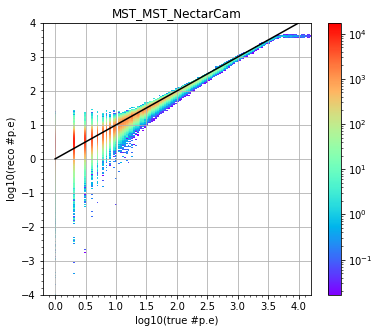

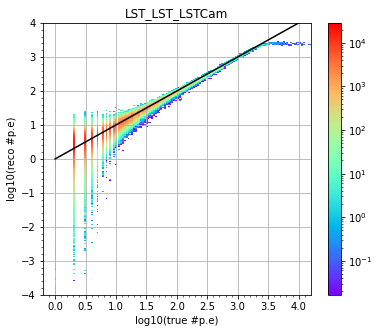

In [16]:
nbins_x = 400
nbins_y = 400

# order by telescope size, largest first
for tel_type in tel_types:

    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("log10(reco #p.e)")
    
    signal_mask = np.where((true_pixel_values[tel_type] >0) & 
                            (reco_pixel_values[tel_type] > 0))
    true = true_pixel_values[tel_type][signal_mask]
    reco = reco_pixel_values[tel_type][signal_mask]
    
    # This is just to count the real number of events given to the histogram
    h_no_weights = plt.hist2d(np.log10(true), 
                              np.log10(reco),
                              bins=[nbins_x, nbins_y],
                              range=[[-7.,5.],[-7.,5.]],
                              norm=LogNorm())
    
    # This histogram has the weights applied, 
    # which chages the number of entries
    # This is also what is plot
    h = plt.hist2d(np.log10(true),
                   np.log10(reco),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,5.],[-7.,5.]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=weights[tel_type][signal_mask])
    
    plt.plot([0, 4], [0, 4], color="black") # line showing perfect correlation
    plt.minorticks_on()
    plt.xticks(ticks=np.arange(-1, 5, 0.5), labels=["",""]+[str(i) for i in np.arange(0, 5, 0.5)])
    plt.xlim(-0.2,4.2)
    plt.ylim(-4.,4.)
    plt.colorbar(h[3], 
                 ax=plt.gca()
                )
    plt.grid()
    
    fig.savefig(f"./plots/calibration_recoPhesVsTruePhes_{tel_type}_protopipe_{analysisName}.png")
    
    # Print some debug/benchmarking information
    print(f"Total number of entries in the plot of {tel_type} (before weighting) = {h_no_weights[0].sum()}")

### Charge resolution
[back to top](#Table-of-contents)

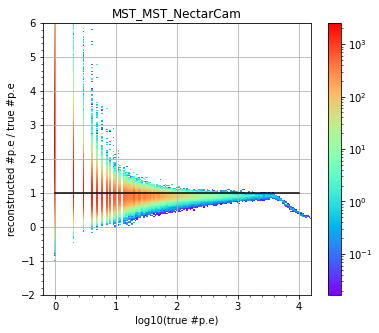

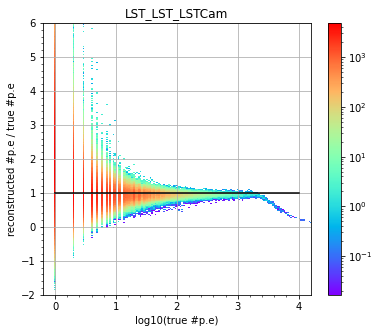

In [17]:
nbins_x = 800
nbins_y = 600

charge_resolution_histogram = {} # camera-wise un-zoomes histogram for calculating bias later on

for tel_type in tel_types:
    
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("reconstructed #p.e / true #p.e")
    
    signal_mask = np.where(true_pixel_values[tel_type] >0)
    true = true_pixel_values[tel_type][signal_mask]
    reco = reco_pixel_values[tel_type][signal_mask]
    
    h = plt.hist2d(np.log10(true), (reco/true),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,15.],[-2,13]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=weights[tel_type][signal_mask],
                  )
    
    charge_resolution_histogram[tel_type] = h
    
    plt.plot([0, 4], [1, 1], color="black") # line showing perfect correlation
    plt.colorbar(h[3], ax=plt.gca()
                 #, format=ticker.FuncFormatter(fmt)
                )
    ax = plt.gca()
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor')
    plt.grid()
    plt.xlim(-0.2,4.2)
    plt.ylim(-2.,6.)

    fig.savefig(f"./plots/calibration_chargeResolution_1stPass_{tel_type}_protopipe_{analysisName}.png")

### Average residual bias
[back to top](#Table-of-contents)

The average bias is calculated in the range from 50 to 500 p.e. to be safely away from saturation and from NSB noise.

**NOTE:**
In the analysis pipeline this bias is not yet corrected, so the definition of what 1 photoelectron is depends on this!

In [18]:
corr = {}
print(f"Correction factors for residual average bias : ")
for tel_type in tel_types:
    corr[tel_type] = calc_bias(charge_resolution_histogram[tel_type][1],
                               charge_resolution_histogram[tel_type][2],
                               charge_resolution_histogram[tel_type][0])
    print(f"- {tel_type} = {corr[tel_type]:.2f}")

Correction factors for residual average bias : 
- MST_MST_NectarCam = 1.10
- LST_LST_LSTCam = 1.05


### Charge resolution corrected for the average residual bias
[back to top](#Table-of-contents)

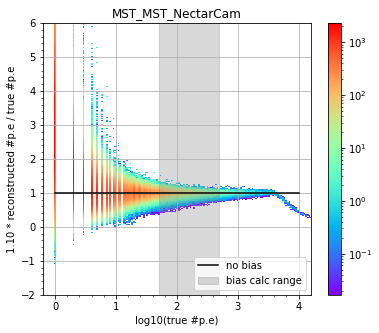

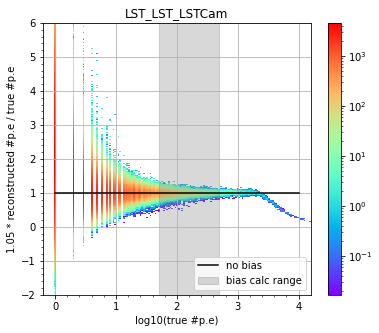

In [19]:
nbins_x = 800
nbins_y = 600

corrected_charge_resolution_histogram = {} # here we store the histograms corrected for the bias to calculate RMS in the next cell

for tel_type in tel_types:
    
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(true #p.e)")
    plt.ylabel(f"{corr[tel_type]:.2f} * reconstructed #p.e / true #p.e")
    
    signal_mask = np.where(true_pixel_values[tel_type] >0)
    true = true_pixel_values[tel_type][signal_mask]
    reco = reco_pixel_values[tel_type][signal_mask]
    
    h = plt.hist2d(np.log10(true), corr[tel_type]*(reco/true),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,15.],[-2,13]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=weights[tel_type][signal_mask],
                  )
    
    corrected_charge_resolution_histogram[tel_type] = h
    
    ax = plt.gca()
    plt.axvspan(np.log10(50.0), 
                np.log10(500.0), 
                ymin=ax.get_ylim()[0], 
                ymax=ax.get_ylim()[1],
                alpha = 0.3,
                color = "grey",
                label = "bias calc range")
    
    plt.plot([0, 4], [1, 1], color="black", label="no bias") # line showing perfect correlation
    plt.colorbar(h[3], ax=plt.gca()
                 #, format=ticker.FuncFormatter(fmt)
                )
    
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor')
    plt.grid()
    plt.legend(loc="lower right")
    plt.xlim(-0.2,4.2)
    plt.ylim(-2.,6.)

    fig.savefig(f"./plots/calibration_chargeResolution_1stPass_biascorrected_{tel_type}_protopipe_{analysisName}.png")

### RMS of charge resolution around 1
[back to top](#Table-of-contents)

**Warning:** CTAMARS data refers to the specific simtel file from the comparison!

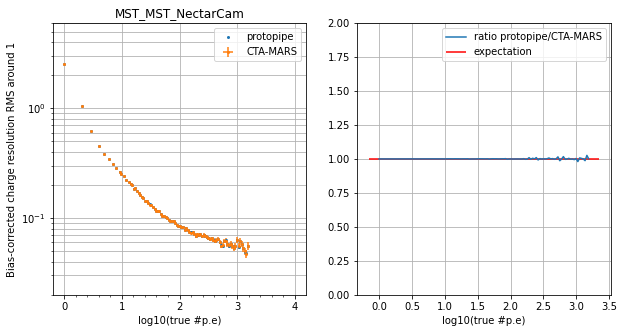

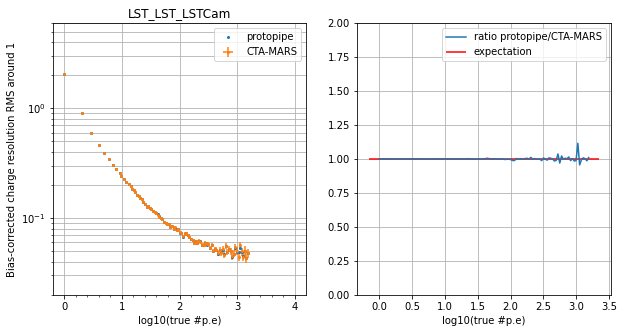

In [20]:
for tel_type in tel_types:
    
    fig = plt.figure(figsize=(10,5), tight_layout=False)
    
    if load_CTAMARS_2019:
        plt.subplot(1,2,1)

    bin_edges_true = corrected_charge_resolution_histogram[tel_type][1]
    bincenters_true = 0.5*(bin_edges_true[1:]+bin_edges_true[:-1]) # mean value of each bin in true photoelectrons
    bin_edges_y = corrected_charge_resolution_histogram[tel_type][2] # bin edges in reconstructed photoelectrons
    bincenters_y = 0.5*(bin_edges_y[1:]+bin_edges_y[:-1]) # mean value of each bin in reconstructed photoelectrons

    # cycle over bins in true photoelectrons:
    values = []
    errors = []
    n = 0
    ref = []

    for true_bin in range(len(bincenters_true)):
        # if the bin center is over 3.2
        if (bincenters_true[true_bin] > 3.2):
            break # stop
        # if it's before -0.5
        if (bincenters_true[true_bin] < -0.5):
            continue # check the next bin
        # else proceed with the calculation
        # take the profile at this X bin along the Y axis
        profile_y = corrected_charge_resolution_histogram[tel_type][0][true_bin] # this is the sequence of weights (aka the heights of the 600 bins)
        # if there is data falling in this X-axis bin,
        if np.sum(profile_y):
            ref.append(true_bin)
            # get the resolution the way Abelardo does
            # to do this we need also the bin centers along the Y axis
            result = calc_rms(bincenters_y, profile_y)
            values.append(result)

            n = n + 1
        else: # otherwise go to the next bin in true photoelectrons
            continue

    values = np.asarray(values)

    # protopipe
    plt.plot(bincenters_true[ref], values, 'o', markersize=2, label="protopipe")

    plt.yscale("log")
    plt.ylim(0.02,6)
    plt.xlim(-0.2,4.2)

    plt.grid(which='both', axis='y')
    plt.grid(which='major', axis='x')
    plt.minorticks_on()
    
    plt.title(tel_type)
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("Bias-corrected charge resolution RMS around 1")
    
    # CTA-MARS
    if load_CTAMARS_2019:
        
        CTAMARS_X = rms[tel_type].member("fX")
        CTAMARS_Y = rms[tel_type].member("fY")
        CTAMARS_EX = rms[tel_type].member("fEX")
        CTAMARS_EY = rms[tel_type].member("fEY")
        plt.errorbar(x = CTAMARS_X,
                     y = CTAMARS_Y, 
                     xerr = CTAMARS_EX, 
                     yerr = CTAMARS_EY,
                     fmt="o", 
                     markersize=2, 
                     label="CTA-MARS")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(CTAMARS_X, values/CTAMARS_Y, label="ratio protopipe/CTA-MARS")
        ax = plt.gca()
        xlims=ax.get_xlim()
        plt.hlines(1., xlims[0], xlims[1], label="expectation", color='r')
        plt.ylim(0, 2)
        plt.grid()
        plt.legend()
        plt.xlabel("log10(true #p.e)")

    plt.show()
    
    fig.savefig(f"./plots/calibration_chargeResolution_RMSaround1_1stPass_{tel_type}_protopipe_{analysisName}.png")

### Single-pixels spectra and optimized cleaning thresholds
[back to top](#Table-of-contents)

**Note:**

If the image extractor uses a double-pass approach, the bias for the cut values calculated from the 2nd pass is calculated from 2nd pass reconstructed charges.

Said this, image extractors such as TwoPassWindowSum are meant to be effective for weak charges, and the bias is anyway calculated between 50 and 500 true p.e. so the difference should be rather small if not insignificant with respect to the bias calculated from the 1st pass.

In [21]:
# Calculate bias for 2nd pass (if any)
if is_double_pass:
    
    nbins_x = 800
    nbins_y = 600

    charge_resolution_2ndPass_histogram = {} # camera-wise un-zoomes histogram for calculating bias later on

    for tel_type in tel_types:

        signal_mask = np.where(true_pixel_values[tel_type] >0)
        true = true_pixel_values[tel_type][signal_mask]
        reco = reco_pixel_values_2ndPass[tel_type][signal_mask]

        h_2ndPass = np.histogram2d(np.log10(true), (reco/true),
                                   bins=[nbins_x, nbins_y],
                                   range=[[-7.,15.],[-2,13]],
                                   weights=weights[tel_type][signal_mask],
                                  )

        charge_resolution_2ndPass_histogram[tel_type] = h_2ndPass

    corr_2ndPass = {}
    print(f"Correction factors for residual average bias (2nd pass) : ")
    for tel_type in tel_types:
        corr_2ndPass[tel_type] = calc_bias(charge_resolution_2ndPass_histogram[tel_type][1],
                                           charge_resolution_2ndPass_histogram[tel_type][2],
                                           charge_resolution_2ndPass_histogram[tel_type][0])
        print(f"- {tel_type} = {corr_2ndPass[tel_type]:.2f}")

Correction factors for residual average bias (2nd pass) : 
- MST_MST_NectarCam = 1.10
- LST_LST_LSTCam = 1.05


In [22]:
def plot_spectrum(x,
                  nbins,
                  total_entries,
                  xrange,
                  **kwargs):

    # make histogram
    hist, xbins = np.histogram(np.log10(x), bins=nbins, range=xrange)
    # plot cumulative histogram
    # each bin is divided by the total number of entries
    plt.semilogy(xbins[:-1], hist[::-1].cumsum()[::-1]/total_entries,
                 **kwargs)
    
    x_values = 0.5 * (xbins[:-1] + xbins[1:])
    y_values = hist[::-1].cumsum()[::-1]/total_entries
    
    return x_values, y_values


Optimized cleaning thresholds for MST_MST_NectarCam obtained from noise rejection:
- BIASED definitions
NOTE: this is the value to be used in the analysis with no bias correction!
5.35 p.e. for 99.0% noise rejection
- UN-BIASED definitions
NOTE: this is the value to be used in the comparison between other pipelines!
5.88 p.e. for 99.0% noise rejection

Optimized cleaning thresholds for LST_LST_LSTCam obtained from noise rejection:
- BIASED definitions
NOTE: this is the value to be used in the analysis with no bias correction!
5.43 p.e. for 99.0% noise rejection
- UN-BIASED definitions
NOTE: this is the value to be used in the comparison between other pipelines!
5.73 p.e. for 99.0% noise rejection


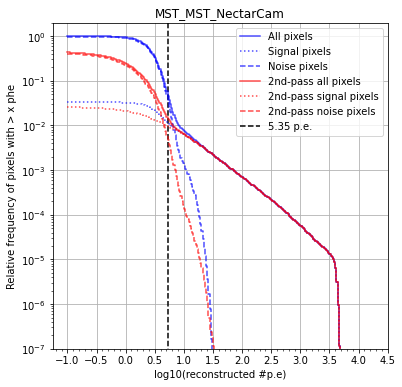

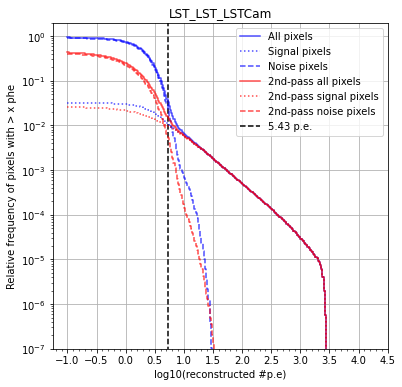

In [23]:
nbins = 250
xrange = [-1,4]

for tel_type in tel_types:
    
    fig = plt.figure(figsize=(6, 6), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(reconstructed #p.e)")
    plt.ylabel("Relative frequency of pixels with > x phe")
    
    true = true_pixel_values[tel_type]
    total_entries = len(true)
    
    log_mask = reco_pixel_values[tel_type] > 0
    reco = reco_pixel_values[tel_type][log_mask]
    signal = reco[true[log_mask] > 0]
    noise = reco[true[log_mask] == 0]
    if is_double_pass:
        log_mask_2 = reco_pixel_values_2ndPass[tel_type] > 0
        reco_2 = reco_pixel_values_2ndPass[tel_type][log_mask_2]
        signal_2 = reco_2[true[log_mask_2] > 0]
        noise_2 = reco_2[true[log_mask_2] == 0]
        
    # Plot 1st-Pass (or unique pass if not a double-pass image extractor)
    
    X, Y = plot_spectrum(reco,
                  nbins,
                  total_entries,
                  xrange,
                  drawstyle="steps-post",
                  alpha=0.7,
                  label="All pixels", 
                  color='blue')
    
    # Plot only signal
    
    plot_spectrum(signal,
                  nbins,
                  total_entries,
                  xrange,
                  drawstyle="steps-post",
                  alpha=0.7,
                  label="Signal pixels",
                  ls="dotted",
                  color='blue')
    
    # Plot only noise
    
    plot_spectrum(noise,
                  nbins,
                  total_entries,
                  xrange,
                  drawstyle="steps-post",
                  alpha=0.7,
                  label="Noise pixels", 
                  ls="dashed",
                  color='blue')
    
    if is_double_pass:
        
        # Plot 2nd-pass
        
        X, Y = plot_spectrum(reco_2,
                      nbins,
                      total_entries,
                      xrange,
                      drawstyle="steps-post",
                      alpha=0.7,
                      label="2nd-pass all pixels", 
                      color='red')
        
        # Plot only signal
    
        plot_spectrum(signal_2,
                      nbins,
                      total_entries,
                      xrange,
                      drawstyle="steps-post",
                      alpha=0.7,
                      label="2nd-pass signal pixels", 
                      ls="dotted",
                      color='red')
        
        # Plot only noise
    
        plot_spectrum(noise_2,
                      nbins,
                      total_entries,
                      xrange,
                      drawstyle="steps-post",
                      alpha=0.7,
                      label="2nd-pass noise pixels", 
                      ls="dashed",
                      color='red')
     
    if is_double_pass:
        quantile = np.quantile(noise_2, noise_rejection_level)
    else:
        quantile = np.quantile(noise, noise_rejection_level)
    
    plt.vlines(np.log10(quantile),
               ymin = plt.gca().get_ylim()[0],
               ymax = plt.gca().get_ylim()[1],
               color="black",
               label=f"{quantile:.2f} p.e.",
               ls="dashed"
               )
    
    plt.minorticks_on()
    plt.ylim(1.e-7, 2.)
    plt.xticks(np.arange(min(xrange), max(xrange)+1, 0.5))
    plt.legend(loc="best")
    plt.grid()
    
    print(f"\nOptimized cleaning thresholds for {tel_type} obtained from noise rejection:")
    print("- BIASED definitions")
    print(f"NOTE: this is the value to be used in the analysis with no bias correction!")
    print(f"{quantile:.2f} p.e. for {noise_rejection_level*100}% noise rejection")
    print("- UN-BIASED definitions")
    print(f"NOTE: this is the value to be used in the comparison between other pipelines!")
    if is_double_pass:
        print(f"{quantile*corr_2ndPass[tel_type]:.2f} p.e. for {noise_rejection_level*100}% noise rejection")
    else:
        print(f"{quantile*corr[tel_type]:.2f} p.e. for {noise_rejection_level*100}% noise rejection")